<a href="https://colab.research.google.com/github/fpgmina/stochastic_simulation/blob/main/GeneratorSubordinatedBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testing convergence for N = [51, 101, 201, 401]

Running for N=51, h=0.8000...

Running for N=101, h=0.4000...

Running for N=201, h=0.2000...

Running for N=401, h=0.1000...


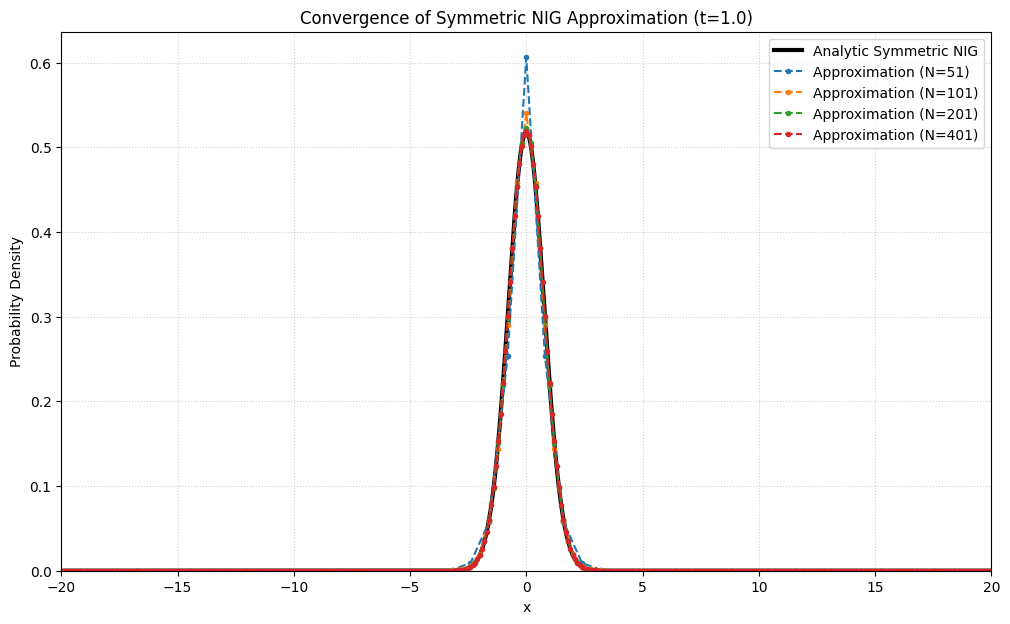

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.linalg import eigh, expm
from scipy.special import k1  # Modified Bessel function of the second kind

# ================================================================
# 1. Discretized Generator for Brownian Motion
# ================================================================

def get_brownian_generator(N, h):
    """
    Construct the generator matrix L_h for a driftless Brownian motion
    on a 1D grid with N points and spacing h.

    Implements (1/2) * Δ_h with absorbing boundary conditions:
        Δ_h f_i = (f_{i-1} - 2f_i + f_{i+1}) / h^2
    """
    h2 = h ** 2
    diag = -1.0 / h2 * np.ones(N)
    off_diag = 0.5 / h2 * np.ones(N - 1)

    # Sparse tridiagonal matrix
    L_h = diags([off_diag, diag, off_diag], [-1, 0, 1], format='csc')
    return L_h


# ================================================================
# 2. Generator for the (symmetric) Normal Inverse Gaussian (NIG) process
# ================================================================

def get_nig_generator(L_h, alpha, delta):
    """
    Construct the generator M_h for a symmetric Normal Inverse Gaussian (NIG) process
    by subordination of Brownian motion.

    The NIG process is defined as:
        X_t = B_{T_t},  where  B is Brownian motion and  T_t  is an IG subordinator.

    Parameters
    ----------
    L_h : sparse matrix
        Discretized Brownian motion generator.
    alpha : float
        Tail parameter (controls kurtosis).
    delta : float
        Scale parameter of the inverse Gaussian subordinator.

    Notes
    -----
    - This implementation assumes a *symmetric* NIG process (β = 0).
      Asymmetry (β ≠ 0) is not supported here because subordination through
      a symmetric Brownian generator cannot introduce skewness.
    """
    L_h_dense = L_h.toarray()

    # Eigen-decomposition of L_h
    eigenvalues, eigenvectors = eigh(L_h_dense)

    # Laplace exponent of IG subordinator for symmetric NIG:
    #   φ(λ) = δ * (α - sqrt(α² - 2λ))
    phi_vals = delta * (alpha - np.sqrt(alpha**2 - 2 * eigenvalues))

    # Reconstruct M_h = V * diag(φ(λ)) * V^T
    M_h = eigenvectors @ np.diag(phi_vals) @ eigenvectors.T
    return M_h


# ================================================================
# 3. Extract Approximate Density from the Transition Matrix
# ================================================================

def get_density_vector(P_t, start_index, h):
    """
    Extracts the approximate probability density at time t
    from the transition matrix P_t.

    Parameters
    ----------
    P_t : ndarray
        Transition matrix exp(M_h * t).
    start_index : int
        Index corresponding to initial position x=0.
    h : float
        Grid spacing.

    Returns
    -------
    ndarray
        Discretized probability density over the grid.
    """
    prob_mass = P_t[start_index].squeeze()
    density = prob_mass / h
    return density


# ================================================================
# 4. Analytic Density of the Symmetric NIG Process
# ================================================================

def analytic_nig_density(x, t, alpha, delta):
    """
    Analytic PDF of the symmetric NIG process (β = 0, μ = 0).

    f(x; t) = (α δ t / π) * exp(δ t α) * K₁(α sqrt((δ t)² + x²)) / sqrt((δ t)² + x²)
    where K₁ is the modified Bessel function of the second kind.
    """
    gamma = alpha  # since β = 0 → γ = α
    arg = np.sqrt((delta * t)**2 + x**2)

    # Avoid division by zero at x = 0
    term2 = np.where(arg > 0, k1(alpha * arg) / arg, 0.0)
    pdf = (alpha * delta * t / np.pi) * np.exp(delta * t * gamma) * term2
    return np.nan_to_num(pdf, nan=0.0)


# ================================================================
# 5. Main Script: Compare Numerical vs. Analytic Densities
# ================================================================

if __name__ == "__main__":
    # Simulation parameters
    L = 40.0           # Domain size [-L/2, L/2]
    t = 1.0            # Time horizon
    N_values = [51, 101, 201, 401]

    # Symmetric NIG parameters (β = 0)
    alpha = 10.0
    delta = 6.0

    plt.figure(figsize=(12, 7))

    # Analytic density on fine grid
    fine_x = np.linspace(-L / 2, L / 2, 1000)
    true_pdf = analytic_nig_density(fine_x, t, alpha, delta)
    plt.plot(fine_x, true_pdf, label="Analytic Symmetric NIG", color="black", linewidth=3)

    print(f"Testing convergence for N = {N_values}")
    for N in N_values:
        h = L / (N - 1)
        grid = np.linspace(-L / 2, L / 2, N)
        start = N // 2

        print(f"\nRunning for N={N}, h={h:.4f}...")

        # 1. Build generators
        L_h = get_brownian_generator(N, h)
        M_h = get_nig_generator(L_h, alpha, delta)

        # 2. Compute transition matrix
        P_t = expm(M_h * t)

        # 3. Extract and plot density
        approx_pdf = get_density_vector(P_t, start, h)
        plt.plot(grid, approx_pdf, "--o", markersize=3, label=f"Approximation (N={N})")

    plt.title(f"Convergence of Symmetric NIG Approximation (t={t})")
    plt.xlabel("x")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True, linestyle=":", alpha=0.6)
    plt.xlim(-L / 2, L / 2)
    plt.ylim(bottom=0)
    plt.show()

# Convergence Analysis

N=  51 | h=0.8000 | MAE=3.88e-03 | Time=0.00s
N= 101 | h=0.4000 | MAE=8.43e-04 | Time=0.01s
N= 201 | h=0.2000 | MAE=1.97e-04 | Time=0.03s
N= 401 | h=0.1000 | MAE=4.89e-05 | Time=0.17s


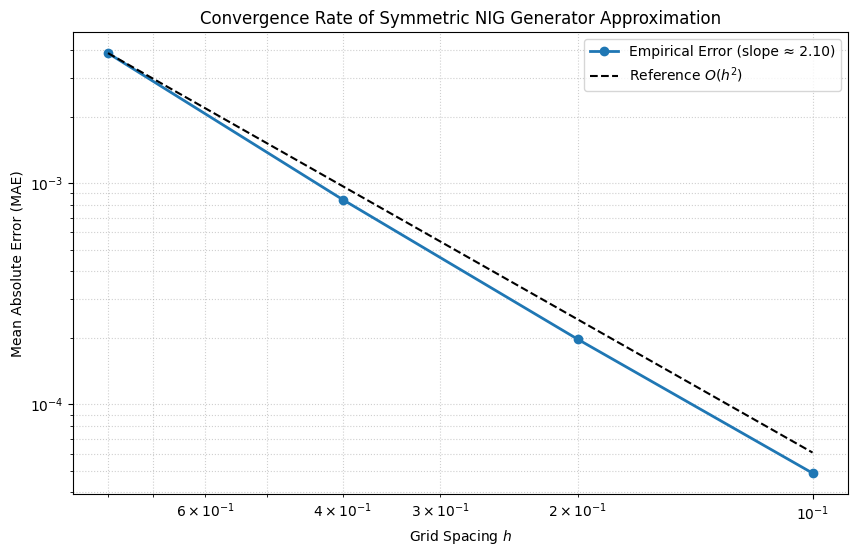

In [23]:
import time
import numpy as np
import matplotlib.pyplot as plt

# ================================================================
# Convergence Study: Error vs. Grid Spacing h
# ================================================================

h_values = []
error_values = []

for N in N_values:
    start_time = time.time()

    # 1. Grid setup
    h = L / (N - 1)
    grid = np.linspace(-L / 2, L / 2, N)
    start = N // 2

    # 2. Build generators and transition matrix
    L_h = get_brownian_generator(N, h)
    M_h = get_nig_generator(L_h, alpha, delta)
    P_t = expm(M_h * t)

    # 3. Compute approximate and analytic densities on same grid
    approx_pdf = get_density_vector(P_t, start, h)
    true_pdf = analytic_nig_density(grid, t, alpha, delta)

    # 4. Mean Absolute Error
    mae = np.mean(np.abs(approx_pdf - true_pdf))

    h_values.append(h)
    error_values.append(mae)

    elapsed = time.time() - start_time
    print(f"N={N:4} | h={h:.4f} | MAE={mae:.2e} | Time={elapsed:.2f}s")

# ================================================================
# Log-Log Convergence Plot
# ================================================================

h_values = np.array(h_values)
error_values = np.array(error_values)

# Linear fit: log(error) = slope * log(h) + intercept
log_h, log_error = np.log(h_values), np.log(error_values)
slope, intercept = np.polyfit(log_h, log_error, 1)

# Reference O(h²) line passing through first point
ref_line = (error_values[0] / (h_values[0] ** 2)) * (h_values ** 2)

plt.figure(figsize=(10, 6))
plt.loglog(h_values, error_values, "o-", label=f"Empirical Error (slope ≈ {slope:.2f})", linewidth=2)
plt.loglog(h_values, ref_line, "k--", label="Reference $O(h^2)$")
plt.title("Convergence Rate of Symmetric NIG Generator Approximation")
plt.xlabel("Grid Spacing $h$")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True, which="both", linestyle=":", alpha=0.6)
plt.gca().invert_xaxis()  # show convergence as h → 0
plt.show()